In [3]:
#Make a catalogue with real and model PSFs + magnitude etc, for PSF testing script

#! /usr/bin/env python
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
#from read_psf_cats import read_data, band_combinations
import fitsio
import treecorr
import matplotlib
import matplotlib
#matplotlib.use('Agg') # needs to be done before import pyplot
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table,join
import h5py as h

from __future__ import print_function
import os
import sys
import shutil
import logging
import datetime
import traceback
import numpy as np
import copy
import glob
import time
import fitsio
#import pixmappy
import pandas
#import galsim
#import galsim.des
#import piff
#import ngmix


In [ ]:
"""ColDefs(
    name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    name = 'FLAGS'; format = '1I'; disp = 'I3'
    name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
    name = 'ERRAWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    name = 'ERRBWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    name = 'ERRTHETAWIN_J2000'; format = '1E'; unit = 'deg'; disp = 'F6.2'
ColDefs(
    name = 'SOURCE_NUMBER'; format = '1J'; disp = 'I10'
    name = 'EXTENSION'; format = '1I'; disp = 'I4'
    name = 'CATALOG_NUMBER'; format = '1J'; disp = 'I7'
    name = 'FLAGS_PSF'; format = '1J'; disp = 'I7'
    name = 'VECTOR_CONTEXT'; format = '2D'; disp = 'G12.6'
    name = 'X_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'DELTAX_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'DELTAY_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'NORM_PSF'; format = '1E'; unit = 'count'; disp = 'G12.6'
    name = 'FWHM_PSF'; format = '1E'; unit = 'pixel'; disp = 'F8.2'
    name = 'ELLIP_PSF'; format = '1E'; disp = 'F7.5'
    name = 'SNR_PSF'; format = '1E'; disp = 'G10.4'
    name = 'CHI2_PSF'; format = '1E'; disp = 'G12.6'
    name = 'RESI_PSF'; format = '1E'; disp = 'G12.6'
"""


In [5]:
def read_files(filter):
    
    sex_file="/global/cscratch1/sd/amichoi/UltraVISTA/cat/UVISTA_%s_21_01_16_psfcat.fits" % (filter)
    
    #def get_data
    dat = fits.open(sex_file)
    cols = dat[2].columns
    #print(cols)
    sex=Table(dat[2].data)
    print("Length of sex file: ", len(sex))
    #sexdf=table_to_python(sex)
    #print("Number of objects in sext file: ",sexdf.shape)
    
    #read in list of stars made from Sextractor and PSFEx
    star_file="/global/homes/a/aamon/DES/DEStests/DEEP/deeppsfs/UltraVista/UVISTA_%s_21_01_16_psfex-starlist.fits" % (filter)

    dat = fits.open(star_file)
    cols = dat[2].columns
    #print(cols)
    star=Table(dat[2].data)
    print("Length of star file: ", len(star))
    """
    #print(star['FLAGS_PSF'])
    star=star[np.where(star['FLAGS_PSF']==0)]
    print("Length of sex file, postcut: ", len(star))"""
    
    sex['X_IMAGE']=sex['X_IMAGE'].astype(int)
    star['X_IMAGE']=star['X_IMAGE'].astype(int)
    sex['Y_IMAGE']=sex['Y_IMAGE'].astype(int)
    star['Y_IMAGE']=star['Y_IMAGE'].astype(int)
    sexstarmerge = join(sex, star, keys=['X_IMAGE','Y_IMAGE'],  join_type='inner')
    
    print("length of merged cat: ", len(sexstarmerge))
    #sexstarmerge =sexstarmerge[np.where(sexstarmerge['FLAGS_PSF']==0)]
    #print("Length of merged cat with only good stars: ", len(sexstarmerge))
    
  
    cols = tuple(name for name in sexstarmerge.colnames if len(sexstarmerge[name].shape) <= 1)
    t2 = sexstarmerge[cols]
    sexstardf = t2.to_pandas()
    #print("Number of objects in PSFEx file: ", stardf.shape)
    
    
    return sexstarmerge, sexstardf

In [ ]:
"""import seaborn as sns; sns.set()
print(min)
sns.scatterplot(x='FWHM_PSF',y='SNR_PSF', hue='FLAGS_PSF',  data=stardf)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10,10**7 )"""

"""plt.scatter(stardf['FWHM_PSF'],stardf['SNR_PSF'],c=stardf['FLAGS_PSF'] , marker='.', label=stardf['FLAGS_PSF'])
plt.xlabel('FWHM')
plt.ylabel('SNR')
plt.ticklabel_format(useOffset=False)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10,10**7 )
plt.legend(stardf['FLAGS_PSF'])"""

0
H
Length of sex file:  281326
Length of star file:  281326
length of merged cat:  195091
FWHM_PSF
--------
 6.08878
 6.15545
 6.29578
 6.22688
 6.17093
 6.49662
 6.08087
 5.70137
 5.92597
 5.69911
     ...
 6.63147
 6.57378
 5.73793
 6.27387
 6.08999
 5.92457
  6.2384
 6.40333
 6.26293
  5.7847
 6.14628
Length = 48139 rows
SNR_PSF
-------
318.128
63.4974
40.0375
28.4368
1523.39
39.8897
28.7579
31.9313
28.9884
29.6546
    ...
32.0379
46.0695
29.8846
66.3988
2652.11
 176.58
48.0962
112.435
202.502
264.064
  41.46
Length = 48139 rows
FLUX_APER [1,48139]
-------------------
  346.197 .. 38.128
FLUX_RADIUS
-----------
    3.04439
    3.07773
    3.14789
    3.11344
    3.08547
    3.24831
    3.04043
    2.85068
    2.96299
    2.84956
        ...
    3.31573
    3.28689
    2.86896
    3.13694
    3.04499
    2.96229
     3.1192
    3.20166
    3.13147
    2.89235
    3.07314
Length = 48139 rows
FLUXERR_APER [1,48139]
----------------------
    2.88409 .. 2.60727
146952
length of merged 

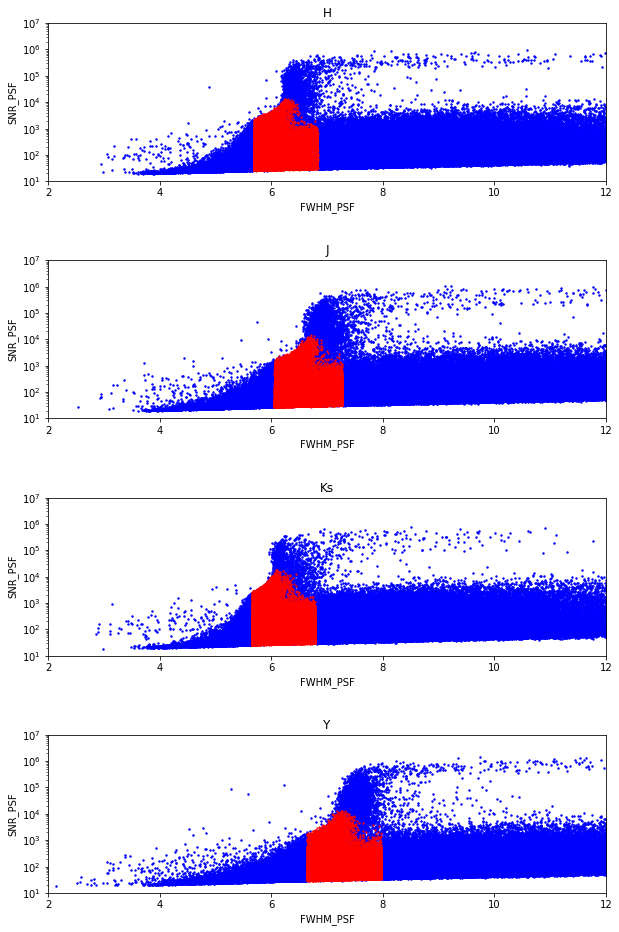

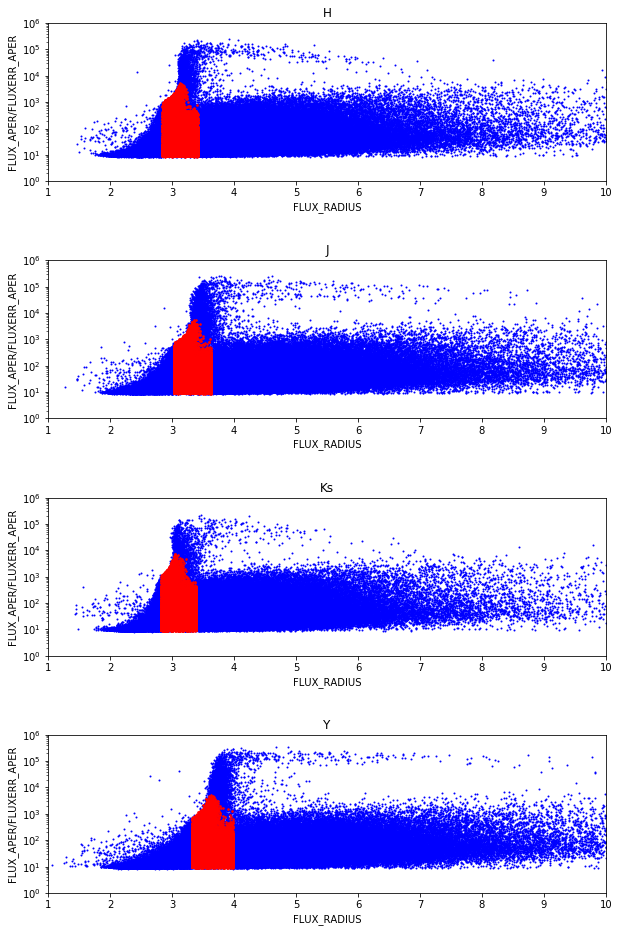

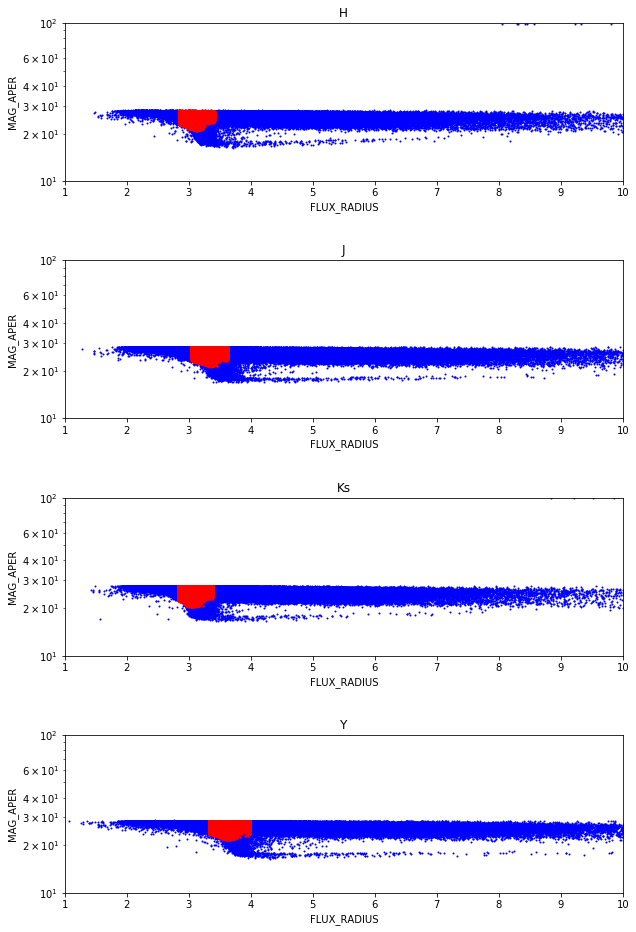

In [13]:
filter=['H', 'J', 'Ks', 'Y']
numfilts=len(filter)

#make figure for fwhm-snr
fig, axs = plt.subplots(4, figsize=(10, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
fig2, axs2 = plt.subplots(4, figsize=(10, 16), facecolor='w', edgecolor='k')
fig2.subplots_adjust(hspace = .5, wspace=.5)
fig3, axs3 = plt.subplots(4, figsize=(10, 16), facecolor='w', edgecolor='k')
fig3.subplots_adjust(hspace = .5, wspace=.5)

#make figure for flux-size
for i in range(numfilts):
    print(i)
    filt=filter[i]
    print(filt)
    
    #sexdata,stardata=read_files(filt)
    sexstar, ssdf=read_files(filt)
    print(sexstar['FWHM_PSF'][np.where(sexstar['FLAGS_PSF']==0)])
    print(sexstar['SNR_PSF'][np.where(sexstar['FLAGS_PSF']==0)])
    print(sexstar['FLUX_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0])
    print(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']==0)])
    print(sexstar['FLUXERR_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0])
    
    #print(ssdf)
    print(len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']!=0)]))
    #match data so can use FLAGS_PSF
    print("length of merged cat: ", len(sexstar))
    print("length of non-stars: ",len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']!=0)]))
    print("length of stars: ",len(sexstar['FLAGS_PSF'][np.where(sexstar['FLAGS_PSF']==0)]))
    
    #add to axes    
    axs[i].scatter(x=sexstar['FWHM_PSF'][np.where(sexstar['FLAGS_PSF']!=0)],y=sexstar['SNR_PSF'][np.where(sexstar['FLAGS_PSF']!=0)],c='blue',label='FLAGS_PSF>0', marker='.',s=8)##,ax=axs[i])
    axs[i].scatter(x=sexstar['FWHM_PSF'][np.where(sexstar['FLAGS_PSF']==0)],y=sexstar['SNR_PSF'][np.where(sexstar['FLAGS_PSF']==0)],c='red',label='FLAGS_PSF=0', marker='.',s=6)##,ax=axs[i])
    #axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim(2,12)
    axs[i].set_ylim(10,10**7 )
    axs[i].set_xlabel('FWHM_PSF')
    axs[i].set_ylabel('SNR_PSF')
    axs[i].set_title(filt)
    #axs[i].legend(sexstar['FLAGS_PSF'])
    
    axs2[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']!=0)],sexstar['FLUX_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],0]/sexstar['FLUXERR_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],0],c='blue',label='FLAGS_PSF>0', marker='.',s=4) # , colormap='viridis')
    axs2[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']==0)],sexstar['FLUX_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0]/sexstar['FLUXERR_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0],c='red',label='FLAGS_PSF=0', marker='.',s=10)
    #plt.xscale('log')
    axs2[i].set_yscale('log')
    axs2[i].set_ylim(1,10**6)
    axs2[i].set_xlim(1,10)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    axs2[i].set_xlabel('FLUX_RADIUS')
    axs2[i].set_ylabel('FLUX_APER/FLUXERR_APER')
    axs2[i].set_title(filt)
    
    axs3[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']!=0)],sexstar['MAG_APER'][[np.where(sexstar['FLAGS_PSF']!=0)],0],c='blue',label='FLAGS_PSF>0', marker='.',s=4) # , colormap='viridis')
    axs3[i].scatter(sexstar['FLUX_RADIUS'][np.where(sexstar['FLAGS_PSF']==0)],sexstar['MAG_APER'][[np.where(sexstar['FLAGS_PSF']==0)],0],c='red',label='FLAGS_PSF=0', marker='.',s=10)
    #plt.xscale('log')
    axs3[i].set_yscale('log')
    axs3[i].set_ylim(10,100)
    axs3[i].set_xlim(1,10)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    axs3[i].set_xlabel('FLUX_RADIUS')
    axs3[i].set_ylabel('MAG_APER')
    axs3[i].set_title(filt)
  
